# Resume / Candidate Screening System

This project implements a machine learning–based resume screening system that:
- Accepts job descriptions and required skills dynamically
- Screens resumes across multiple domains
- Ranks candidates based on job relevance
- Identifies missing skills for each candidate

The system is domain-agnostic and mirrors real Applicant Tracking Systems (ATS).


In [ ]:
import pandas as pd
import numpy as np
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
df = pd.read_csv("Resume.csv")

df.head()


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


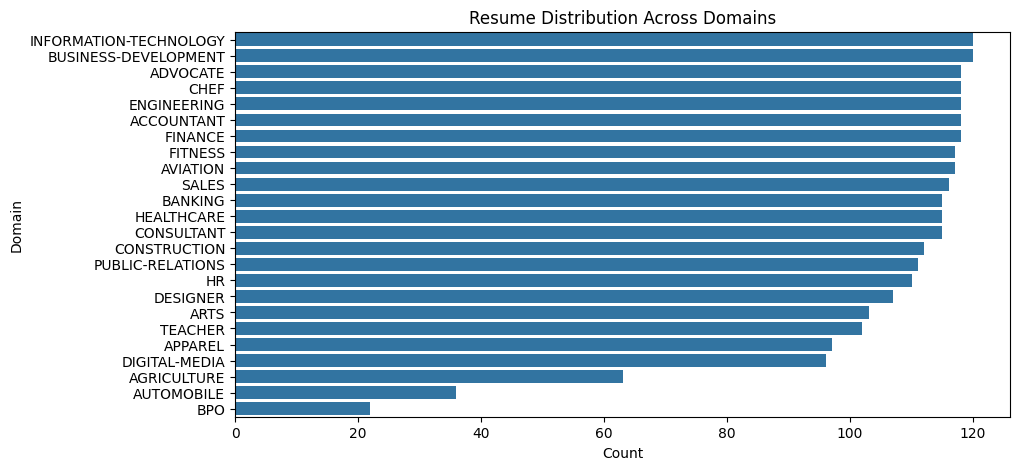

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(y=df['Category'], order=df['Category'].value_counts().index)
plt.title("Resume Distribution Across Domains")
plt.xlabel("Count")
plt.ylabel("Domain")
plt.show()


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)


In [ ]:
df['clean_resume'] = df['Resume_str'].apply(clean_text)


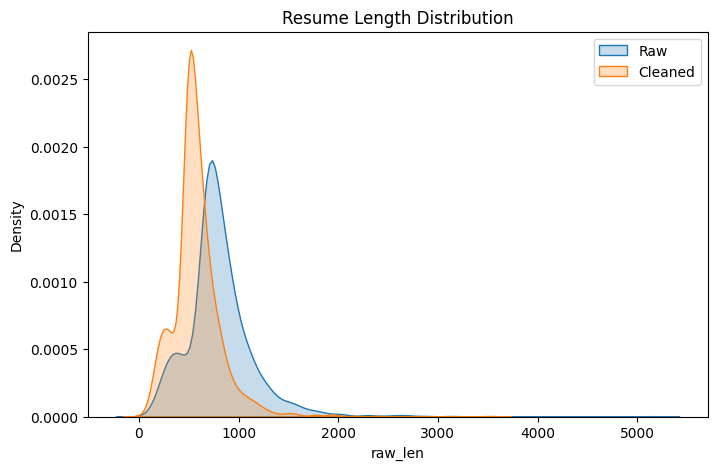

In [ ]:
df['raw_len'] = df['Resume_str'].apply(lambda x: len(x.split()))
df['clean_len'] = df['clean_resume'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.kdeplot(df['raw_len'], label="Raw", fill=True)
sns.kdeplot(df['clean_len'], label="Cleaned", fill=True)
plt.title("Resume Length Distribution")
plt.legend()
plt.show()


In [ ]:
job_description = """
We are looking for a Data Scientist with strong Python and Machine Learning skills.
Experience with Pandas, NumPy, SQL, and Scikit-learn is required.
"""

required_skills = [
    "python",
    "machine learning",
    "pandas",
    "numpy",
    "sql",
    "scikit-learn"
]


In [ ]:
def extract_skills(text, skills):
    found = []
    for skill in skills:
        if skill.lower() in text:
            found.append(skill)
    return found


In [ ]:
df['matched_skills'] = df['clean_resume'].apply(
    lambda x: extract_skills(x, required_skills)
)

df['missing_skills'] = df['matched_skills'].apply(
    lambda x: list(set(required_skills) - set(x))
)


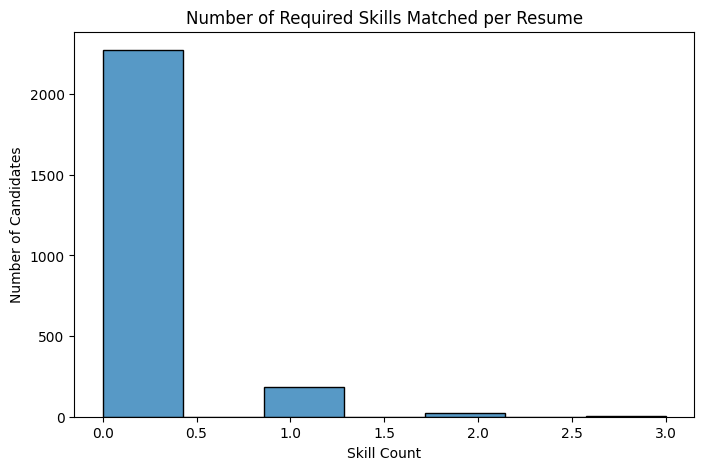

In [ ]:
df['skill_count'] = df['matched_skills'].apply(len)

plt.figure(figsize=(8,5))
sns.histplot(df['skill_count'], bins=len(required_skills)+1)
plt.title("Number of Required Skills Matched per Resume")
plt.xlabel("Skill Count")
plt.ylabel("Number of Candidates")
plt.show()


In [ ]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(
    df['clean_resume'].tolist() + [clean_text(job_description)]
)

similarity_scores = cosine_similarity(
    tfidf_matrix[:-1],
    tfidf_matrix[-1:]
).flatten()

df['similarity_score'] = similarity_scores


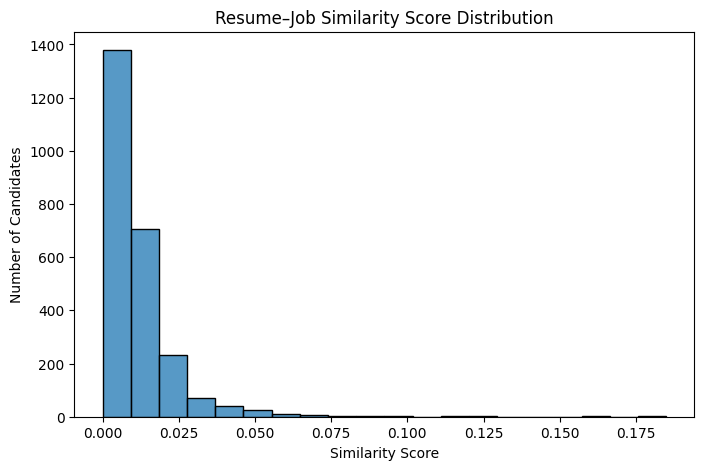

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['similarity_score'], bins=20)
plt.title("Resume–Job Similarity Score Distribution")
plt.xlabel("Similarity Score")
plt.ylabel("Number of Candidates")
plt.show()


In [28]:
df['skill_ratio'] = df['skill_count'] / len(required_skills)
df['final_score'] = (
    0.7 * df['similarity_score'] +
    0.3 * df['skill_ratio']
)


In [29]:
df_ranked = df.sort_values(
    by='final_score',
    ascending=False
).reset_index(drop=True)

df_ranked['Rank'] = df_ranked.index + 1


In [30]:
df_ranked[['Rank',
           'ID',
           'Resume_str',
           'final_score',
           'similarity_score',
           'matched_skills',
           'missing_skills']].head(10)


,Rank,ID,Resume_str,final_score,similarity_score,matched_skills,missing_skills
0,1,12011623,ENGINEERING AND QUALITY TECHNICIAN ...,0.262864,0.161235,"[python, machine learning, sql]","[scikit-learn, pandas, numpy]"
1,2,18448085,DATA ANALYST Professional Summa...,0.262858,0.161225,"[python, numpy, sql]","[scikit-learn, pandas, machine learning]"
2,3,21156767,Pavithra Shetty Summary ...,0.234202,0.120289,"[python, machine learning, sql]","[scikit-learn, pandas, numpy]"
3,4,62994611,SOFTWARE DEVELOPER Professi...,0.229469,0.184956,"[python, sql]","[scikit-learn, machine learning, pandas, numpy]"
4,5,34953092,"CORPORATE BANKING ASSISTANT, INTERN ...",0.214459,0.092084,"[python, machine learning, sql]","[scikit-learn, pandas, numpy]"
5,6,22946204,Highlights Prog. Languages: ...,0.207955,0.082793,"[python, machine learning, sql]","[scikit-learn, pandas, numpy]"
6,7,50328713,ENGINEERING INTERN Skills ...,0.177951,0.039929,"[python, machine learning, sql]","[scikit-learn, pandas, numpy]"
7,8,42156237,SENIOR DIGITAL MARKETING ANALYST ...,0.166290,0.094699,"[python, sql]","[scikit-learn, machine learning, pandas, numpy]"
8,9,18067556,MASTER DATA MANAGER Experie...,0.153363,0.076233,"[python, sql]","[scikit-learn, machine learning, pandas, numpy]"
9,10,14871762,BUSINESS DEVELOPMENT EXECUTIVE ...,0.151433,0.073476,"[python, sql]","[scikit-learn, machine learning, pandas, numpy]"


### Final Candidate Ranking with Composite Scoring

This table presents the final ranked list of candidates generated by the resume screening system.  
Ranking is based on a **composite score** that combines semantic relevance and explicit skill matching:

**Final Score** = 0.7 × Similarity Score + 0.3 × Skill Match Ratio


**Interpretation of Results:**

- Candidates ranked at the top demonstrate a strong balance between contextual relevance to the job description and possession of required skills.
- For example, top-ranked candidates show consistent overlap in core skills such as *Python*, *Machine Learning*, and *SQL*, while also exhibiting meaningful semantic similarity to the target role.
- Candidates with slightly lower similarity scores may still rank highly if they match a greater number of required skills, highlighting the system’s ability to reward explicit qualifications.
- Conversely, candidates with higher semantic similarity but fewer matched skills are ranked lower, reflecting the importance of skill completeness in the final decision.
- The `matched_skills` and `missing_skills` columns provide transparent, explainable insights that help recruiters understand why a candidate was ranked at a particular position and identify areas where upskilling may be required.

Overall, this composite scoring approach enables fair, explainable, and role-adaptive candidate screening, supporting informed hiring decisions across multiple job domains.


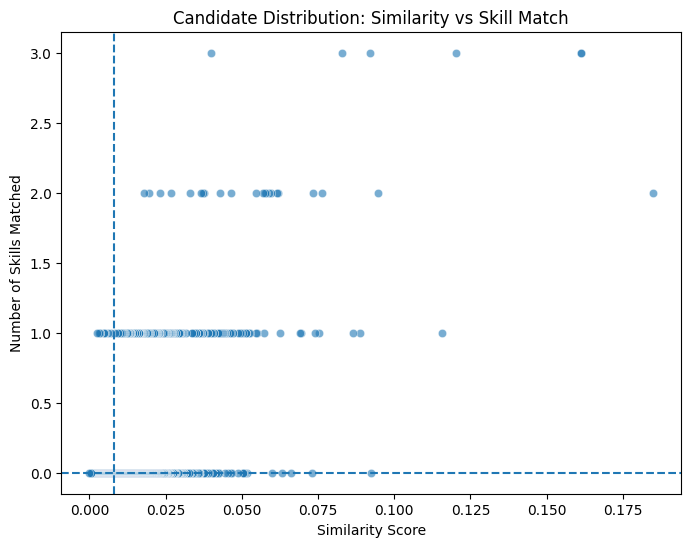

In [34]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='similarity_score',
    y='skill_count',
    data=df_ranked,
    alpha=0.6
)

plt.axvline(df_ranked['similarity_score'].median(), linestyle='--')
plt.axhline(df_ranked['skill_count'].median(), linestyle='--')

plt.title("Candidate Distribution: Similarity vs Skill Match")
plt.xlabel("Similarity Score")
plt.ylabel("Number of Skills Matched")
plt.show()


### Candidate Distribution: Similarity vs Skill Match

This scatter plot visualizes candidates based on two key dimensions:

- **Resume–Job Similarity Score (X-axis):** Measures semantic alignment between the resume and job description.
- **Number of Required Skills Matched (Y-axis):** Represents explicit skill overlap with job requirements.

The dashed vertical and horizontal lines represent threshold values that divide candidates into four decision regions:

**Quadrant I (High Similarity, High Skill Match)**  
Candidates in this region show strong contextual relevance and possess most of the required skills. These profiles represent the best fit for the role and are prioritized for shortlisting.

**Quadrant II (Low Similarity, High Skill Match)**  
These candidates possess relevant skills but their resume context differs from the target job role. They may be suitable for roles requiring domain transition or additional contextual training.

**Quadrant III (Low Similarity, Low Skill Match)**  
Candidates in this region lack both semantic relevance and required skills. Such profiles are typically filtered out by the screening system.

**Quadrant IV (High Similarity, Low Skill Match)**  
These candidates demonstrate strong contextual alignment with the job description but miss some required skills. They are potential candidates who may be considered for upskilling or training programs.

This visualization enables recruiters to make informed, explainable decisions by balancing semantic relevance with explicit skill matching.


In [32]:
import os

output_dir = "results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

df_ranked.to_csv(os.path.join(output_dir, "ranked_candidates.csv"), index=False)

In [33]:
rank_cand = pd.read_csv("results/ranked_candidates.csv")

rank_cand.head()

,ID,Resume_str,Resume_html,Category,clean_resume,raw_len,clean_len,matched_skills,missing_skills,skill_count,similarity_score,skill_ratio,final_score,Rank
0,12011623,ENGINEERING AND QUALITY TECHNICIAN ...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING,engineering quality technician career overview...,915,638,"['python', 'machine learning', 'sql']","['scikit-learn', 'pandas', 'numpy']",3,0.161235,0.500000,0.262864,1
1,18448085,DATA ANALYST Professional Summa...,"<div class=""fontsize fontface vmargins hmargin...",AUTOMOBILE,data analyst professional summary industrial s...,462,333,"['python', 'numpy', 'sql']","['scikit-learn', 'pandas', 'machine learning']",3,0.161225,0.500000,0.262858,2
2,21156767,Pavithra Shetty Summary ...,"<div class=""RNA skn-mlf9 fontsize fontface vma...",CONSULTANT,pavithra shetty summary customeroriented princ...,749,540,"['python', 'machine learning', 'sql']","['scikit-learn', 'pandas', 'numpy']",3,0.120289,0.500000,0.234202,3
3,62994611,SOFTWARE DEVELOPER Professi...,"<div class=""MPR skn-cbg1 fontsize fontface vma...",AGRICULTURE,software developer professional summary enthus...,1101,775,"['python', 'sql']","['scikit-learn', 'machine learning', 'pandas',...",2,0.184956,0.333333,0.229469,4
4,34953092,"CORPORATE BANKING ASSISTANT, INTERN ...","<div class=""fontsize fontface vmargins hmargin...",BANKING,corporate banking assistant intern objective d...,406,288,"['python', 'machine learning', 'sql']","['scikit-learn', 'pandas', 'numpy']",3,0.092084,0.500000,0.214459,5
